In [16]:
from PIL import Image
import os
import pathlib
import time
from torch.utils.data import Dataset, DataLoader
import glob
import tqdm
import random
import matplotlib.pyplot as plt
import gc
import torch
from torch import Tensor
from torch import nn
import torch.optim as Toptim
from torchvision.models import vgg19
from torch.autograd.variable import Variable
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from typing import Tuple, Dict, List

In [17]:
class Flickr2kDataset(Dataset):
    
    def __init__(self, dir : str, transform_LR = None, transform_HR = None) -> None:
        self.paths = list(pathlib.Path(data_path).glob("*.png"))
        self.transform_LR = transform_LR
        self.transform_HR = transform_HR
    
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index : int) -> Tuple[torch.Tensor, torch.Tensor]:
        img = self.load_image(index)
        if self.transform_LR and self.transform_HR:
            return self.transform_LR(img), self.transform_HR(img)
        else:
            return img

In [18]:
data_LR_transforms = T.Compose([
    T.Resize((64,64)),
    T.ToTensor(),
])
data_HR_transforms = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
])

In [23]:
data_path = pathlib.Path("/kaggle/input/flickr2k/Flickr2K/Flickr2K_HR") # Provide your own path
Flickr2k_dataset = Flickr2kDataset(dir = data_path, transform_LR = data_LR_transforms, transform_HR = data_HR_transforms)

In [24]:
len(Flickr2k_dataset)

2650

In [25]:
def display_random_images(dataset : torch.utils.data.dataset.Dataset,
                          n: int = 1,
                          seed : int = None):
    if seed:
        random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    
    
    for i , sample in enumerate(random_samples_idx):
        sample_image_LR, sample_image_HR = dataset[sample]
        
    fig = plt.figure(figsize = (16, 8))
    
    fig.add_subplot(1,2,1)
    plt.axis("off")
    plt.title(f"Image Size: {sample_image_LR.permute(1,2,0).shape}")
    plt.imshow(sample_image_LR.permute(1,2,0))
    
    fig.add_subplot(1,2,2)
    plt.axis("off")
    plt.title(f"Image Size: {sample_image_HR.permute(1,2,0).shape}")
    plt.imshow(sample_image_HR.permute(1,2,0))

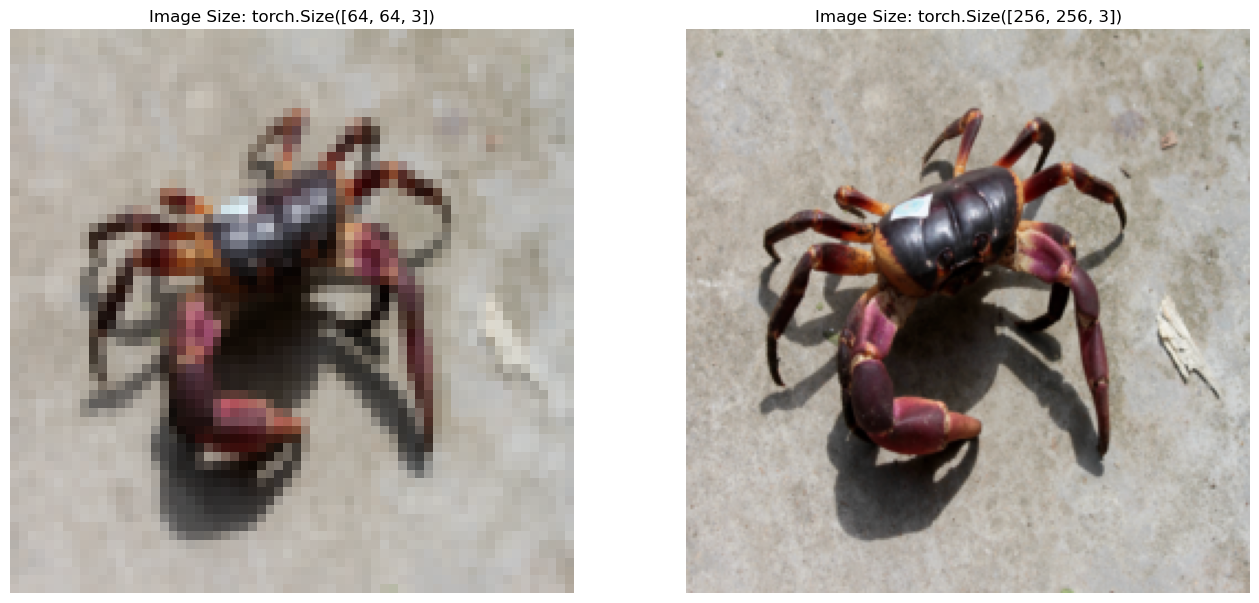

In [26]:
display_random_images(Flickr2k_dataset, seed = 123)

In [30]:
epoch = 0
n_epochs = 40
batch_size = 5
lr = 0.0005
beta1 = 0.5
beta2 = 0.999
decay_epoch = 20
n_cpu = 2
hr_height = 256
hr_width = 256
channels = 3
sample_interval = 100
checkpoint_interval = -1
hr_shape = (hr_height, hr_width)

train_params = {"batch_size": batch_size, "shuffle": True, "num_workers": n_cpu}
train_dataloader = DataLoader(Flickr2k_dataset, **train_params)

sample_image_lr, sample_image_hr = next(iter(train_dataloader))
sample_image_lr.shape, sample_image_hr.shape

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math


class FeatureExtracter(nn.Module):
    def __init__(self):
        super(FeatureExtracter, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(Generator, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [32]:
generator = Generator()
discriminator = Discriminator(input_shape = (channels, *hr_shape))
feature_extracter = FeatureExtracter()
feature_extracter.eval()

cuda = torch.cuda.is_available()
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    
    feature_extracter = feature_extracter.cuda()
    gan_loss = gan_loss.to(device)
    content_loss = content_loss.cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 85.4MB/s] 


NameError: name 'gan_loss' is not defined

In [33]:
# Here also provide your own path
generator.load_state_dict(torch.load('/kaggle/input/modelSRG/generator_model_epoch_35.pth', map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load("/kaggle/input/modelSRG/discriminator_model_epoch_35.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [36]:
def test_generator(model, number):
    model.eval()
    with torch.inference_mode():
        for i, (batch_lr, batch_hr) in enumerate(train_dataloader):
            real = Tensor(batch_lr.size(0), 1).fill_(1).to(device)
            fake = Tensor(batch_lr.size(0), 1).fill_(0).to(device)
    
            imgs_real_lr = batch_lr.to(device)
            imgs_real_hr = batch_hr
            sample = model(imgs_real_lr)

            fig = plt.figure(figsize = (16, 8))
            fig.add_subplot(1,3,1)
            plt.axis("off")
            plt.title(f"Image Size: {imgs_real_lr[0].permute(1,2,0).shape}")
            plt.imshow(imgs_real_lr[0].permute(1,2,0).cpu())

            fig.add_subplot(1,3,3)
            plt.axis("off")
            plt.title(f"Image Size: {imgs_real_hr[0].permute(1,2,0).shape}")
            plt.imshow(imgs_real_hr[0].permute(1,2,0).cpu())

            fig.add_subplot(1,3,2)
            plt.axis("off")
            plt.title(f"Image Size: {sample[0].permute(1,2,0).shape}")
            plt.imshow(sample[0].permute(1,2,0).detach().cpu())
            plt.savefig(f'/kaggle/working/hr_{epoch}.png')
            break
    

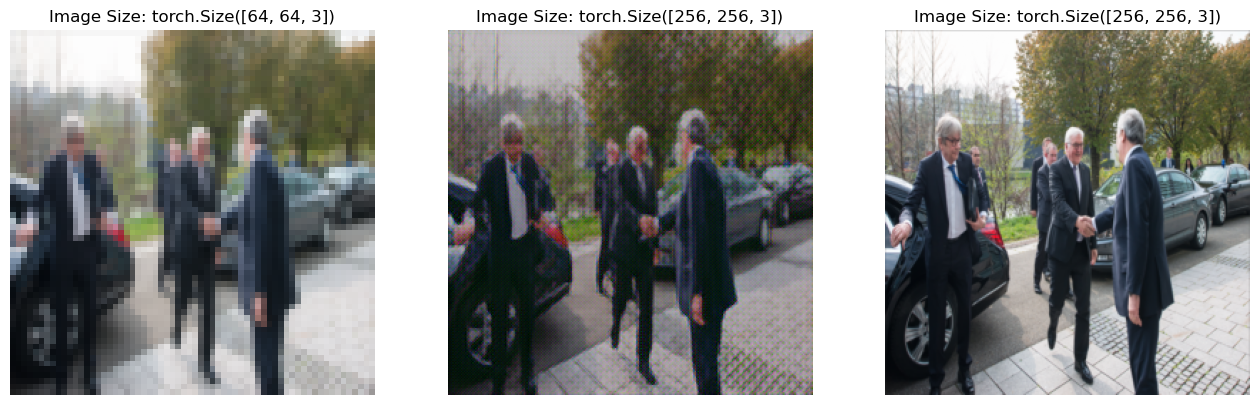

In [37]:
test_generator(model = generator, number = 4)